## Exposure, EE, PFE, and Netting: Theory and Mathematics

### 1. Positive Exposure  
Defines the amount at risk when a contract has positive mark‑to‑market.  
$$
E(t) \;=\; \max\bigl(V(t),\,0\bigr)
$$

### 2. Expected Exposure (EE)  
The average discounted positive exposure under the risk‑neutral measure \(\mathbb{Q}\).  
$$
\mathrm{EE}(t) \;=\; \mathbb{E}^{\mathbb{Q}}\!\Bigl[\tfrac{E(t)}{M_t}\Bigr]
\quad\text{where}\quad
M_t = \exp\!\Bigl(\!\int_{0}^{t}r_s\,ds\Bigr)
$$

### 3. Potential Future Exposure (PFE)  
The \(\alpha\)-quantile of the future positive exposure distribution.  
$$
\mathrm{PFE}_\alpha(t)
\;=\;
\inf\bigl\{\,x \mid \Pr\bigl(E(t)\le x\bigr)\ge \alpha\bigr\}
$$

### 4. Netting Effect  
When multiple trades with the same counterparty offset each other, net exposure is reduced.  
- **Net Exposure**:  
  $$
  E_{\rm net}(t)
  \;=\;
  \max\Bigl(\sum_{i=1}^{n}V_i(t),\,0\Bigr)
  $$
- **Net Expected Exposure** and **Net PFE** computed by replacing \(E(t)\) with \(E_{\rm net}(t)\) in the EE and PFE formulas above.

---

**Connection to Quant Finance**  
These metrics form the backbone of **counterparty credit risk** modelling. Banks simulate exposures across many scenarios to calculate regulatory capital (Basel III CVA), price bilateral CVA/DVA, and assess how netting agreements in ISDA master agreements reduce capital charges.

---

**Nitish Sir (Hinglish Explanation)**  
“Positive exposure ka simple formula $E(t)=\max(V(t),0)$ hai. Phir discounted average EE ke liye $\mathrm{EE}(t)=\mathbb{E}[E/M]$ nikaalte hain, aur extreme case ke liye quantile se PFE milta hai. Jab multiple swaps net hote hain, toh $E_{\rm net}(t)=\max(\sum V_i,0)$ se exposure kaafi ghatt jaata hai—iske benefits CVA capital mein directly nazar aate hain.”


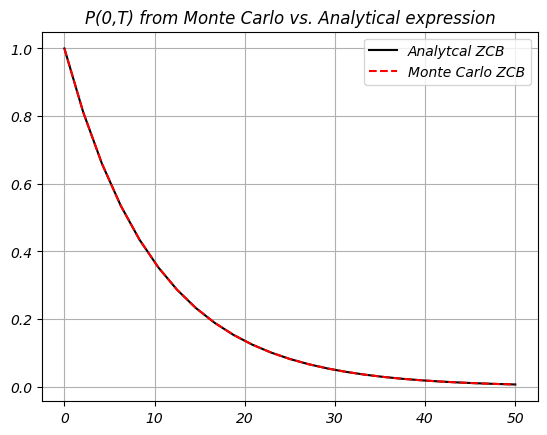

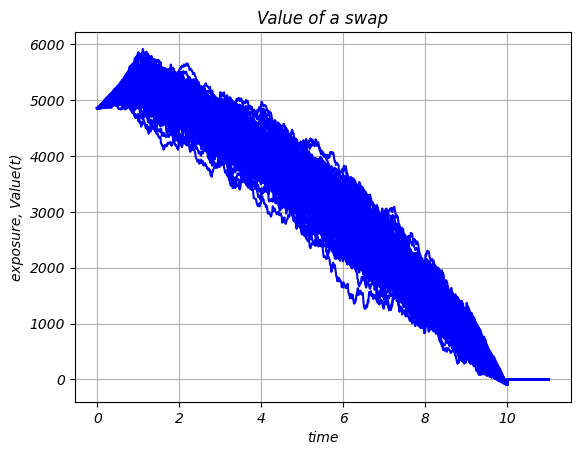

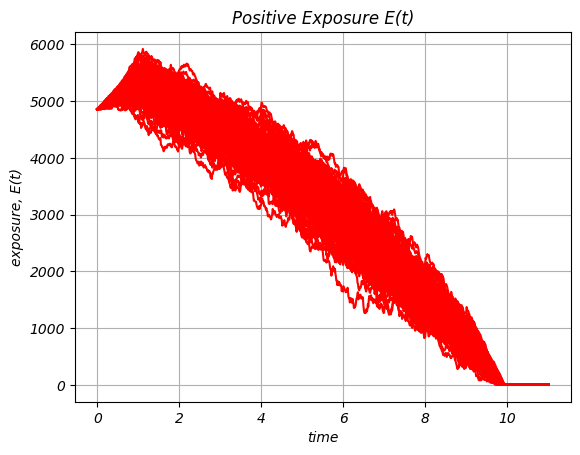

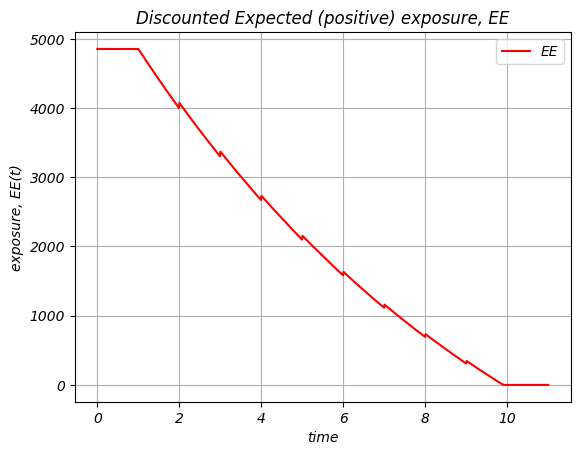

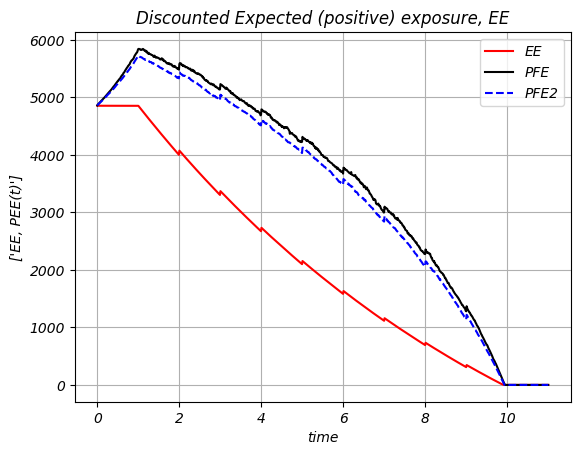

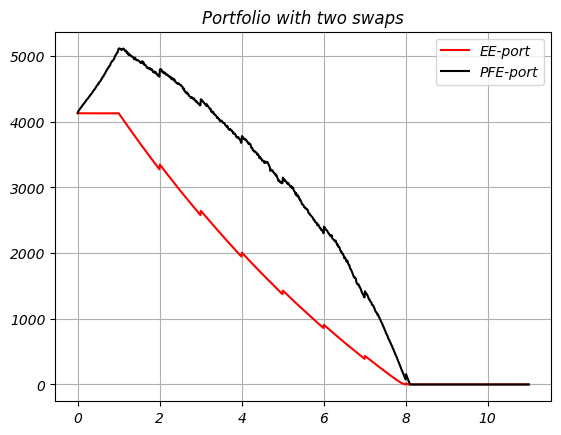

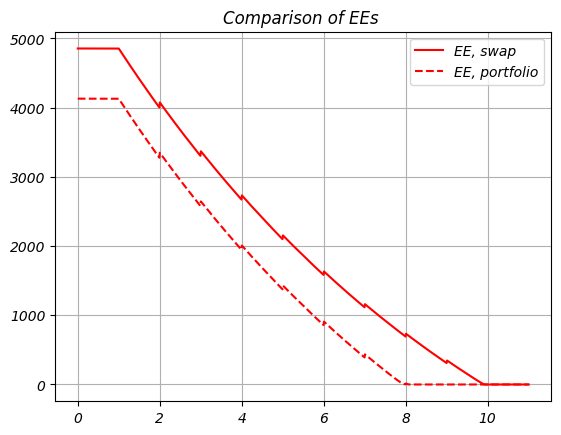

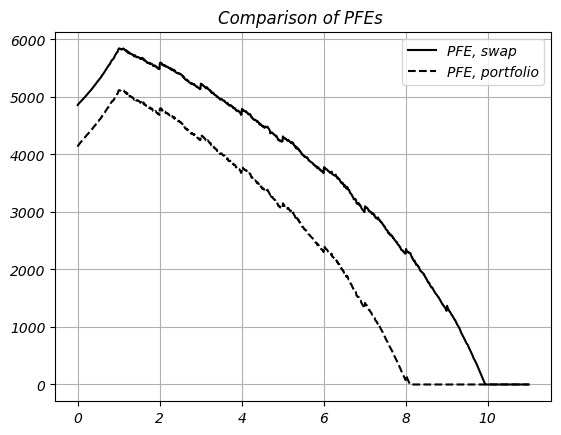

In [1]:
import numpy as np
import enum
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate


# This class defines puts and calls
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0


def GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)

    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = lambda t: 1.0 / lambd * (f0T(t + dt) - f0T(t - dt)) / (2.0 * dt) + f0T(t) + eta * eta / (
                2.0 * lambd * lambd) * (1.0 - np.exp(-2.0 * lambd * t))

    # theta = lambda t: 0.1 +t -t
    # print("changed theta")

    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    R = np.zeros([NoOfPaths, NoOfSteps + 1])
    R[:, 0] = r0
    time = np.zeros([NoOfSteps + 1])

    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i + 1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]
        R[:, i + 1] = R[:, i] + lambd * (theta(time[i]) - R[:, i]) * dt + eta * (W[:, i + 1] - W[:, i])
        time[i + 1] = time[i] + dt

    # Outputs
    paths = {"time": time, "R": R}
    return paths


def HW_theta(lambd, eta, P0T):
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    theta = lambda t: 1.0 / lambd * (f0T(t + dt) - f0T(t - dt)) / (2.0 * dt) + f0T(t) + eta * eta / (
                2.0 * lambd * lambd) * (1.0 - np.exp(-2.0 * lambd * t))
    # print("CHANGED THETA")
    return theta  # lambda t: 0.1+t-t


def HW_A(lambd, eta, P0T, T1, T2):
    tau = T2 - T1
    zGrid = np.linspace(0.0, tau, 250)
    B_r = lambda tau: 1.0 / lambd * (np.exp(-lambd * tau) - 1.0)
    theta = HW_theta(lambd, eta, P0T)
    temp1 = lambd * np.trapz(theta(T2 - zGrid) * B_r(zGrid), zGrid)

    temp2 = eta * eta / (4.0 * np.power(lambd, 3.0)) * (
                np.exp(-2.0 * lambd * tau) * (4 * np.exp(lambd * tau) - 1.0) - 3.0) + eta * eta * tau / (
                        2.0 * lambd * lambd)

    return temp1 + temp2


def HW_B(lambd, eta, T1, T2):
    return 1.0 / lambd * (np.exp(-lambd * (T2 - T1)) - 1.0)


def HW_ZCB(lambd, eta, P0T, T1, T2, rT1):
    n = np.size(rT1)

    if T1 < T2:
        B_r = HW_B(lambd, eta, T1, T2)
        A_r = HW_A(lambd, eta, P0T, T1, T2)
        return np.exp(A_r + B_r * rT1)
    else:
        return np.ones([n])


def HWMean_r(P0T, lambd, eta, T):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2.0 * dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = HW_theta(lambd, eta, P0T)
    zGrid = np.linspace(0.0, T, 2500)
    temp = lambda z: theta(z) * np.exp(-lambd * (T - z))
    r_mean = r0 * np.exp(-lambd * T) + lambd * np.trapz(temp(zGrid), zGrid)
    return r_mean


def HW_r_0(P0T, lambd, eta):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    return r0


def HW_Mu_FrwdMeasure(P0T, lambd, eta, T):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = HW_theta(lambd, eta, P0T)
    zGrid = np.linspace(0.0, T, 500)

    theta_hat = lambda t, T: theta(t) + eta * eta / lambd * 1.0 / lambd * (np.exp(-lambd * (T - t)) - 1.0)

    temp = lambda z: theta_hat(z, T) * np.exp(-lambd * (T - z))

    r_mean = r0 * np.exp(-lambd * T) + lambd * np.trapz(temp(zGrid), zGrid)

    return r_mean


def HWVar_r(lambd, eta, T):
    return eta * eta / (2.0 * lambd) * (1.0 - np.exp(-2.0 * lambd * T))


def HWDensity(P0T, lambd, eta, T):
    r_mean = HWMean_r(P0T, lambd, eta, T)
    r_var = HWVar_r(lambd, eta, T)
    return lambda x: stats.norm.pdf(x, r_mean, np.sqrt(r_var))


def HW_SwapPrice(CP, notional, K, t, Ti, Tm, n, r_t, P0T, lambd, eta):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid = np.array([Ti, Tm])
    else:
        ti_grid = np.linspace(Ti, Tm, n)
    tau = ti_grid[1] - ti_grid[0]

    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid < t)]
    if np.size(prevTi) > 0:  # prevTi != []:
        Ti = prevTi[-1]

    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid > t)]

    temp = np.zeros(np.size(r_t));

    P_t_TiLambda = lambda Ti: HW_ZCB(lambd, eta, P0T, t, Ti, r_t)

    for (idx, ti) in enumerate(ti_grid):
        if ti > Ti:
            temp = temp + tau * P_t_TiLambda(ti)

    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)

    if CP == OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP == OptionTypeSwap.RECEIVER:
        swap = K * temp - (P_t_Ti - P_t_Tm)

    return swap * notional


def mainCalculation():
    NoOfPaths = 2000
    NoOfSteps = 1000
    lambd = 0.5
    eta = 0.03
    notional = 10000.0
    notional2 = 10000.0
    alpha = 0.99
    alpha2 = 0.95

    P0T = lambda T: np.exp(-0.1 * T)
    r0 = HW_r_0(P0T, lambd, eta)
    # In this experiment we compare ZCB from the Market and Analytical expression
    N = 25
    T_end = 50
    Tgrid = np.linspace(0, T_end, N)

    Exact = np.zeros([N, 1])
    Proxy = np.zeros([N, 1])
    for i, Ti in enumerate(Tgrid):
        Proxy[i] = HW_ZCB(lambd, eta, P0T, 0.0, Ti, r0)
        Exact[i] = P0T(Ti)
    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid, Exact, '-k')
    plt.plot(Tgrid, Proxy, '--r')
    plt.legend(["Analytcal ZCB", "Monte Carlo ZCB"])
    plt.title('P(0,T) from Monte Carlo vs. Analytical expression')
    # Swap settings
    K = 0.01  # strike
    Ti = 1.0  # begining of the swap
    Tm = 10.0  # end date of the swap
    n = 10  # number of payments between Ti and Tm

    paths = GeneratePathsHWEuler(NoOfPaths, NoOfSteps, Tm + 1.0, P0T, lambd, eta)
    r = paths["R"]
    timeGrid = paths["time"]
    dt = timeGrid[1] - timeGrid[0]
    M_t = np.zeros([NoOfPaths, NoOfSteps])

    for i in range(0, NoOfPaths):
        M_t[i, :] = np.exp(np.cumsum(r[i, 0:-1]) * dt)

        # protfolio without netung
    Value = np.zeros([NoOfPaths, NoOfSteps + 1])
    E = np.zeros([NoOfPaths, NoOfSteps + 1])
    EE = np.zeros([NoOfSteps + 1])
    PFE = np.zeros([NoOfSteps + 1])
    PFE2 = np.zeros([NoOfSteps + 1])
    for idx, ti in enumerate(timeGrid[0:-2]):
        V = HW_SwapPrice(OptionTypeSwap.PAYER, notional, K, timeGrid[idx], Ti, Tm, n, r[:, idx], P0T, lambd, eta)
        Value[:, idx] = V
        E[:, idx] = np.maximum(V, 0.0)
        EE[idx] = np.mean(E[:, idx] / M_t[:, idx])
        PFE[idx] = np.quantile(E[:, idx], alpha)
        PFE2[idx] = np.quantile(E[:, idx], alpha2)

    # portfolio with nettinh
    ValuePort = np.zeros([NoOfPaths, NoOfSteps + 1])
    EPort = np.zeros([NoOfPaths, NoOfSteps + 1])
    EEPort = np.zeros([NoOfSteps + 1])
    PFEPort = np.zeros([NoOfSteps + 1])

    for (idx, ti) in enumerate(timeGrid[0:-2]):
        Swap1 = HW_SwapPrice(OptionTypeSwap.PAYER, notional, K, timeGrid[idx], Ti, Tm, n, r[:, idx], P0T, lambd, eta)
        Swap2 = HW_SwapPrice(OptionTypeSwap.RECEIVER, notional2, 0.0, timeGrid[idx], Tm - 2.0 * (Tm - Ti) / n, Tm, 1,
                             r[:, idx], P0T, lambd, eta)

        VPort = Swap1 + Swap2
        ValuePort[:, idx] = VPort
        EPort[:, idx] = np.maximum(VPort, 0.0)
        EEPort[idx] = np.mean(EPort[:, idx] / M_t[:, idx])
        PFEPort[idx] = np.quantile(EPort[:, idx], alpha)

    plt.figure(2)
    plt.plot(timeGrid, Value[0:100, :].transpose(), 'b')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('exposure, Value(t)')
    plt.title('Value of a swap')

    plt.figure(3)
    plt.plot(timeGrid, E[0:100, :].T, 'r')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('exposure, E(t)')
    plt.title('Positive Exposure E(t)')

    plt.figure(4)
    plt.plot(timeGrid, EE, 'r')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('exposure, EE(t)')
    plt.title('Discounted Expected (positive) exposure, EE')
    plt.legend(['EE', 'PFE'])

    plt.figure(5)
    plt.plot(timeGrid, EE, 'r')
    plt.plot(timeGrid, PFE, 'k')
    plt.plot(timeGrid, PFE2, '--b')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel(['EE, PEE(t)'])
    plt.title('Discounted Expected (positive) exposure, EE')
    plt.legend(['EE', 'PFE', 'PFE2'])

    plt.figure(6)
    plt.plot(timeGrid, EEPort, 'r')
    plt.plot(timeGrid, PFEPort, 'k')
    plt.grid()
    plt.title('Portfolio with two swaps')
    plt.legend(['EE-port', 'PFE-port'])

    plt.figure(7)
    plt.plot(timeGrid, EE, 'r')
    plt.plot(timeGrid, EEPort, '--r')
    plt.grid()
    plt.title('Comparison of EEs ')
    plt.legend(['EE, swap', 'EE, portfolio'])

    plt.figure(8)
    plt.plot(timeGrid, PFE, 'k')
    plt.plot(timeGrid, PFEPort, '--k')
    plt.grid()
    plt.title('Comparison of PFEs ')
    plt.legend(['PFE, swap', 'PFE, portfolio'])


mainCalculation()






